In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from utils.input_pipeline import get_image_folders
from utils.diagnostic import top_k_accuracy, count_params,\
    entropy, model_calibration, predict

torch.cuda.is_available()

True

# Load the model

In [3]:
from get_densenet import get_model

In [4]:
_, val_folder = get_image_folders()

In [5]:
model, _, _ = get_model()

# load pretrained quantized model
model.load_state_dict(torch.load('model_ternary_quantization.pytorch_state'))

In [6]:
# number of params in the model
count_params(model)

440264

# Show some quantized kernel tensors (there are 62 such kernels overall)

In [7]:
# all quantized kernels
all_kernels = [
    (n, p.data) for n, p in model.named_parameters() 
    if ('denseblock' in n or 'transition' in n) and 'conv' in n
]

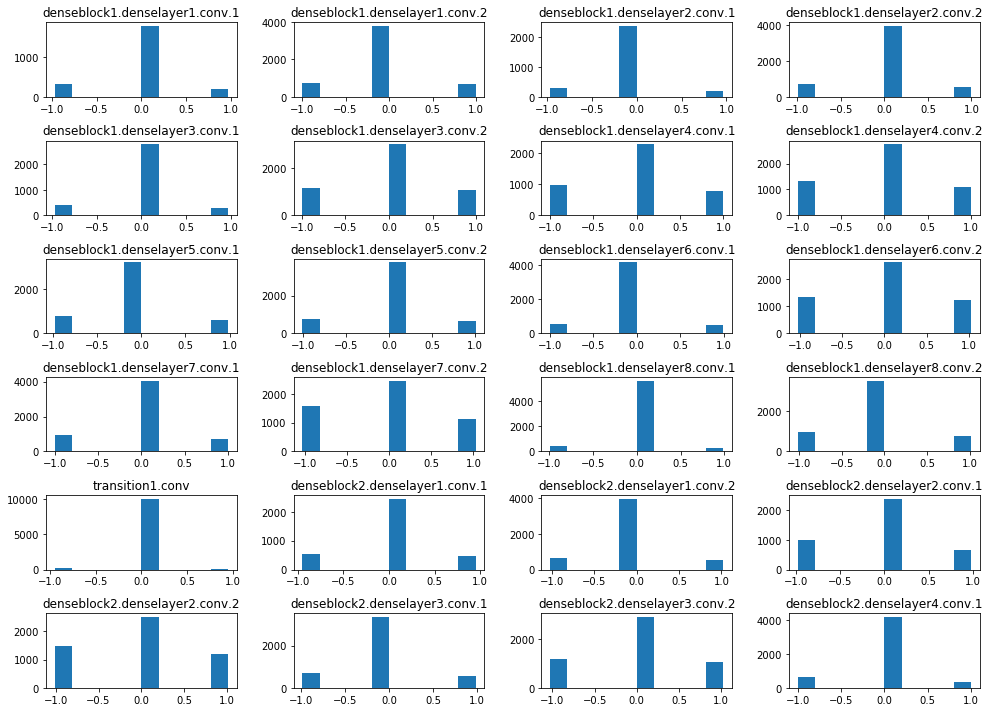

In [8]:
# show distribution of weights in kernels that are in the beginning of the network 
_, axes = plt.subplots(nrows=6, ncols=4, figsize=(14, 10))
axes = axes.flatten()
for i, (name, kernel) in enumerate(all_kernels[:24]):
    axes[i].hist(kernel.cpu().numpy().reshape(-1));
    axes[i].set_title(name[9:-7]);

plt.tight_layout()

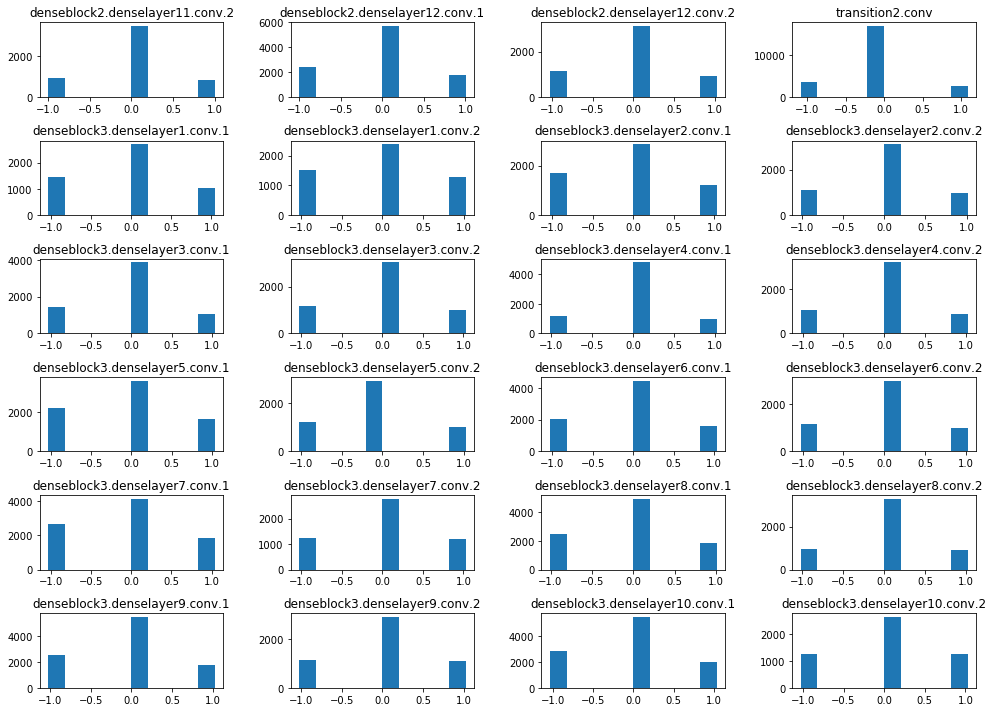

In [9]:
# kernels in the end of the network 
_, axes = plt.subplots(nrows=6, ncols=4, figsize=(14, 10))
axes = axes.flatten()
for i, (name, kernel) in enumerate(all_kernels[-24:]):
    axes[i].hist(kernel.cpu().numpy().reshape(-1));
    axes[i].set_title(name[9:-7]);

plt.tight_layout()

# sparcity distribution

In [10]:
sparcity = []
for n, p in all_kernels:
    sparcity.append(p.eq(0.0).float().mean())

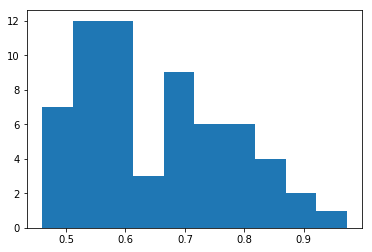

In [11]:
plt.hist(sparcity);

In [12]:
np.mean(sparcity)

0.64925934855015044

# scaling factors

In [13]:
upper_scaling_factor = []
lower_scaling_factor = []
for n, p in all_kernels:
    upper_scaling_factor.append(p.max())
    lower_scaling_factor.append(p.min())

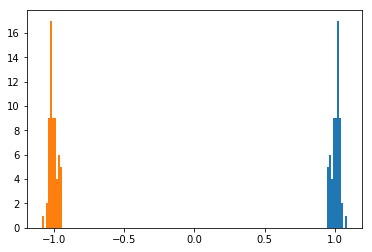

In [14]:
plt.hist(upper_scaling_factor);
plt.hist(lower_scaling_factor);

# Error analysis

### get all predictions

In [15]:
val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=64, shuffle=False
)

In [16]:
val_predictions, val_true_targets = predict(model, val_iterator_no_shuffle)

100%|██████████| 157/157 [00:26<00:00,  5.96it/s]


### logloss and accuracies

In [17]:
log_loss(val_true_targets, val_predictions)

2.7472481686929204

In [18]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.37380000000000002

In [19]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.49540000000000001, 0.55930000000000002, 0.60870000000000002, 0.6472, 0.75700000000000001]


### number of misclassified images (there are overall 10000 images in the val dataset)

In [20]:
hits = val_predictions.argmax(1) == val_true_targets
(~hits).sum()

6262

### entropy of predictions

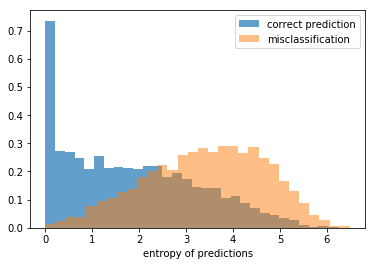

In [21]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

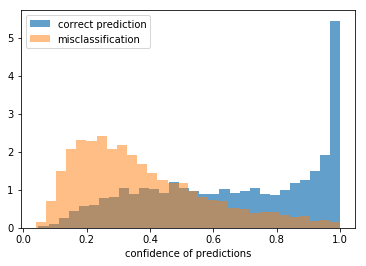

In [22]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

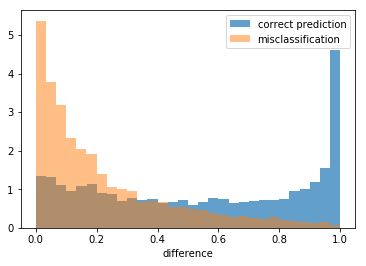

In [23]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

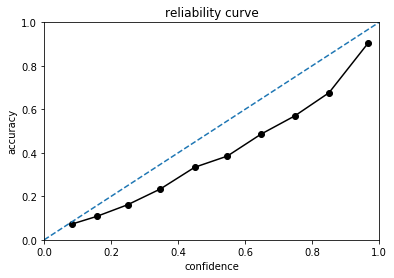

In [24]:
model_calibration(val_true_targets, val_predictions, n_bins=10)